In [2]:
%matplotlib inline
import pandas as pd
import cycluster as cy
import os.path as op
import numpy as np
import palettable
from custom_legends import colorLegend
import seaborn as sns
from hclusterplot import *
import matplotlib.pyplot as plt
import pprint
import openpyxl
from plotnine import *
# import preprocessing as prep
import scipy.cluster.hierarchy as sch
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import sklearn
import matplotlib as mpl
import itertools
from scipy.spatial import distance
import os
import plotting as plot
import matplotlib.patches as mpatches
from texttable import Texttable

In [3]:
path = "./"
inf = "/Users/NBrah/PycharmProjects/St_Jude/Cycluster"
file = op.join(path,inf)
os.chdir(file)

cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster


In [4]:
sns.set_context('paper')
path = "./"
inf = "Flu09 Plasma Data.csv"
dataFilename = op.join(path,inf)
"""A long df has one analyte measurement per row"""
longDf = pd.read_csv(dataFilename)
path_1 = './'
inf_1 = 'Demographics.csv'
dataFilename_1 = op.join(path_1,inf_1)
demographics = pd.read_csv(dataFilename_1)
# demo = demographics.pivot_table(index=['ID', 'Strain'])
# print(demo)

# print(demographics.Age.between(0,10,True).values)

demo_list = []
for i in range(len((demographics.ID.values))):
    if ((demographics.Strain.isin(['Negative']).values))[i] == True:
        demo_list += [demographics.ID[i]]
# print(demo_list)
longDf = longDf.drop(columns= ['SJ', 'Season', 'Type'])
longDf = longDf.loc[longDf.Sample.isin(demo_list)]
longDf = longDf.loc[longDf.Day.between(0,20,True)]
longDf['Sample_1']=longDf['Sample'].astype(str)+'_'+longDf['Day'].astype(str)
longDf = longDf.drop(columns= ['Day'])
longDf = longDf.drop(columns= ['Sample'])
Df = longDf.pivot_table(index='Sample_1')
# print(longDf)
# print(Df)


# print(longDf.loc[longDf.Day.isin([0])])

LogDf = Df.apply(func=np.log,axis=0)
print(LogDf)
# LogDf.to_excel('Ontologix_Test.xlsx')

                  EGF   Eotaxin      FGF2       FKN  Flt3 Ligand      GCSF  \
Sample_1                                                                     
1002.0_0.0   4.347823  5.266362  1.806648  3.054473    -0.400478  2.335052   
1003.0_0.0   4.663439  4.003143  4.882802  5.902633     3.902377  1.637053   
1006.0_0.0   4.820282  4.196901  4.962845  6.575076     4.146779  2.339881   
1007.0_0.0   4.691348  4.048126  4.890349  6.445720     4.215382  1.294727   
1009.0_0.0   4.927254  4.410371  5.135798  6.826545     4.459913 -0.198451   
1010.0_0.0   4.804021  4.166200  5.017280  6.790097     4.323735  2.618855   
1012.0_0.0   5.249337  3.264614  0.307485  2.542389    -0.400478  3.469790   
1013.0_0.0   4.750395  4.133245  2.384165  3.819908    -0.400478  2.882564   
1014.0_0.0   5.462857  4.856240  2.738256  3.795264     2.975530  2.751748   
1015.0_0.0   4.840242  3.868698  3.070376  3.955657    -0.400478  3.379633   
1016.0_0.0   5.558140  4.049696  4.048824  4.593705    -0.400478

In [6]:
def meanSubNormalize(cyDf, cyVars=None, compCommVars=None, meanVar=None):
    """Normalize cytokine columns by the log-mean for each patient, within each compartment.
    The point is that if cytokine concentrations are generally high for one sample or another,
    this might dominate the covariation of cytokines across patients (both within/across compartments).

    We subtract off the mean since the "overall inflamation" level
    that we are adjusting for would probably be on the fold-change concentration scale.
    (additive on the log-concentration scale)"""
    def _normFuncSub(vec):
        out = vec - muVec
        return out

    if cyVars is None:
        cyVars = cyDf.columns
    if meanVar is None:
        meanVar = 'Mean'
    if compCommVars is None:
        cyDf.columns

    """No standardizing cytokines before taking the mean (need units to stay in log-concentration)"""
    muVec = cyDf[cyDf.columns].mean(axis=1)
    
    ndf = cyDf.copy()
    ndf.loc[:, cyDf.columns] = ndf[cyDf.columns].apply(_normFuncSub)
    ndf.loc[:, meanVar] = muVec
    return ndf



# Df_values = longDf.drop(columns="Sample")
# Df_values = Df_values.drop(columns="GRO")
# print(Df_values)
# muVec = Df_values[Df_values.columns].mean(axis=1)
# print(Df_values[Df_values.columns])
# print(muVec)
# print(Df_values.isnull().sum())
df_prep = meanSubNormalize(LogDf)
df_prep = df_prep.drop(columns = "Mean")
print(df_prep)

                  EGF   Eotaxin      FGF2       FKN  Flt3 Ligand      GCSF  \
Sample_1                                                                     
1002.0_0.0   2.096904  3.015443 -0.444271  0.803553    -2.651397  0.084133   
1003.0_0.0   0.370425 -0.289871  0.589788  1.609619    -0.390637 -2.655961   
1006.0_0.0   0.274818 -0.348562  0.417381  2.029612    -0.398685 -2.205583   
1007.0_0.0   0.267428 -0.375794  0.466429  2.021800    -0.208539 -3.129193   
1009.0_0.0   0.242940 -0.273943  0.451484  2.142231    -0.224401 -4.882765   
1010.0_0.0   0.196701 -0.441120  0.409959  2.182777    -0.283585 -1.988466   
1012.0_0.0   4.122978  2.138254 -0.818875  1.416030    -1.526837  2.343431   
1013.0_0.0   2.486996  1.869845  0.120766  1.556508    -2.663877  0.619164   
1014.0_0.0   3.345557  2.738940  0.620956  1.677964     0.858229  0.634448   
1015.0_0.0   2.823693  1.852149  1.053827  1.939108    -2.417027  1.363084   
1016.0_0.0   2.852543  1.344098  1.343227  1.888107    -3.106075

In [7]:
cwd = os.getcwd()
print(cwd)
path = "./"
inf = "/Users/NBrah/PycharmProjects/St_Jude/Cycluster/Flu09 Plasma"
file = op.join(path,inf)
os.chdir(file)
cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster\Flu09 Plasma
C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster\Flu09 Plasma


All1
IFNg
VEGF

All2
FGF2
FKN
GMCSF
IFNa2
MCP3

All3
IL1Ra2
IL1b

All4
IL10
IL12p40
IL13
IL15
IL1a
IL2
IL3
IL4
IL5
IL9
TNFb

All5
Flt3 Ligand
IL12p70
IL17

All6
IL6

All7
Eotaxin
GCSF
IP10
MCP1
MDC

All8
EGF
GRO
IL8
MIP1a
MIP1b
TGFa
TNFa



C:\Users\NBrah\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


[-0.120328    0.27305689  0.34178571  0.45326295  0.52672445  0.55840947
  0.65991138  0.66748181  0.69719904  0.70782492  0.7327086   0.76067759
  0.78324606  0.80684856  0.83748637  0.87034779  0.90450344  0.92665332
  1.01171668  1.05790786  1.09895421  1.17306629  1.22831501  1.30225986
  1.32970513  1.39640963  1.47520005  1.55771395  1.63582051  1.73085842]
All1
IFNg
VEGF

All2
IL1Ra2
IL1b

All3
IL10
IL12p40
IL13
IL15
IL1a
IL2
IL3
IL4
IL5
IL9
TNFb

All4
Eotaxin
GCSF
IP10
MCP1
MDC

All5
EGF
GRO
IL8
MIP1a
MIP1b
TGFa
TNFa

All6
FGF2
FKN

All7
GMCSF
IFNa2
MCP3

All8
Flt3 Ligand
IL12p70
IL17

All9
IL6

All1
IFNg
VEGF

All2
IL1Ra2
IL1b

All3
IL13
IL1a

All4
IL10
IL12p40
IL15
IL2
IL3
IL4
IL5
IL9
TNFb

All5
IL6
MIP1b
TNFa

All6
Eotaxin
GCSF
IP10
MCP1
MDC

All7
EGF
GRO
IL8
MIP1a
TGFa

All8
Flt3 Ligand
IL12p70
IL17

All9
FGF2
FKN

All10
GMCSF
IFNa2
MCP3

All1
IFNg
VEGF

All2
IL1Ra2
IL1b

All3
IL13
IL1a

All4
IL2
IL4
IL5

All5
IL10
IL12p40
IL15
IL3
IL9
TNFb

All6
IL6
IL8
MIP1a
MIP1b
TNFa

A

<Figure size 1440x1080 with 0 Axes>

<Figure size 864x720 with 0 Axes>

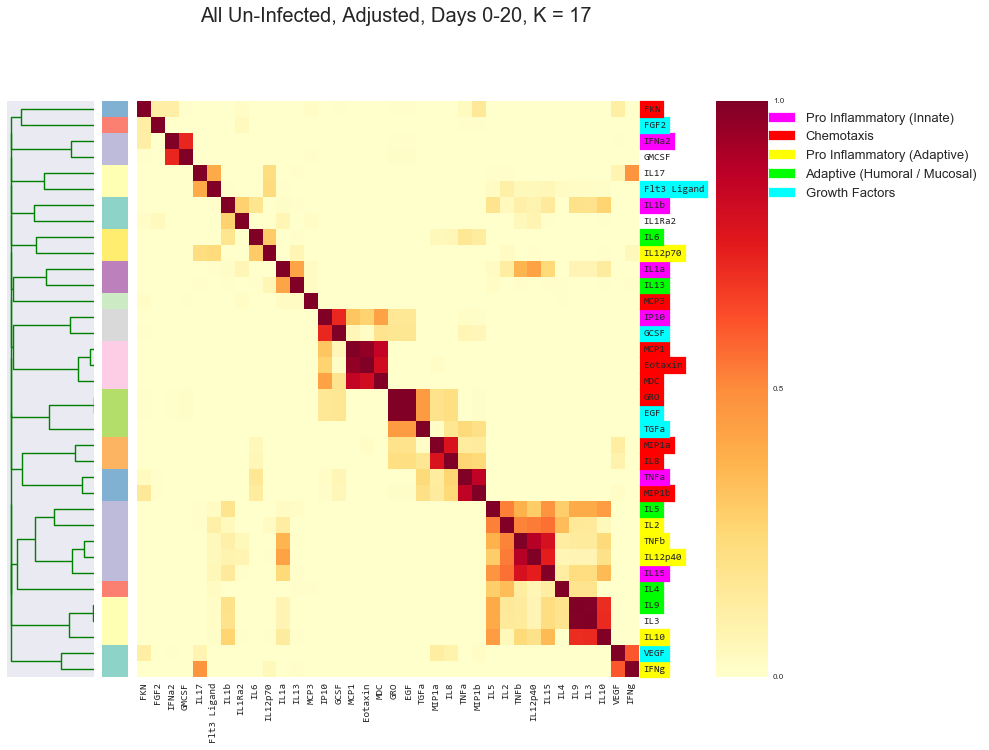

In [179]:
def computeGapStat(data, pdistFunc, clusterFunc, maxK, bootstraps=1000):
    dmat = pdistFunc(data)

    lsICD = np.zeros(maxK)
    mBSICD = np.zeros(maxK)
    stdBSICD = np.zeros(maxK)

    for K in (np.arange(maxK) + 1):
        labels = clusterFunc(dmat, K)
        lsICD[K - 1] = np.log(_intra_cluster_distances(dmat, labels))
        reps = np.zeros(bootstraps)
        for i in range(bootstraps):
            tmpDmat = pdistFunc(_bootstrap_each_column(data))
            labels = clusterFunc(tmpDmat, K)
            reps[i] = np.log(_intra_cluster_distances(tmpDmat, labels))
        mBSICD[K - 1] = reps.mean()
        stdBSICD[K - 1] = reps.std()

    gap = mBSICD - lsICD
    errBSICD = np.sqrt(1 + 1. / bootstraps) * stdBSICD

    return lsICD, mBSICD, errBSICD, gap

def _intra_cluster_distances(dmat, labels):
    """Sum of the intra-cluster distances (Wk)"""
    K = len(np.unique(labels))
    tot = 0
    for k in np.unique(labels):
        ind = labels == k
        nk = ind.sum()
        if isinstance(dmat, pd.DataFrame):
            tot += (dmat.loc[ind, :].loc[:, ind].values.flatten() ** 2).sum() / (2 * nk)
        else:
            tot += (dmat[ind, :][:, ind].flatten() ** 2).sum() / (2 * nk)
    return tot

def _bootstrap_each_column(d):
    """Returns a copy of data with row-bootstraped values
    substituted for each column independently."""
    out = d.copy()

    if isinstance(out, pd.DataFrame):
        out = out.apply(lambda col: col[np.floor(np.random.rand(len(col)) * len(col)).astype(int)], axis=0, raw=True)
    else:
        for ci in range(d.shape[1]):
            rind = np.floor(np.random.rand(d.shape[0]) * d.shape[0]).astype(int)
            out[:, ci] = out[rind, ci]

    return out




def plotGapStat(lsICD, mBSICD, errBSICD, gap, filename):
    """Descriptive plot of the Gap statistic.
    Parameters are simply the output from computeGapStat."""

    maxK = len(gap)
    plt.clf()
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(maxK) + 1, np.exp(lsICD) / np.exp(lsICD[0]), 'o-', color='black', label='Observed data')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('Summed intra-cluster distances\nas a fraction of total\n pairwise distance', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    plt.ylim((0, 1))

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(maxK) + 1, lsICD, 'o-', color='black', label='Observed data')
    plt.plot(np.arange(maxK) + 1, mBSICD, 'o-', color='red', label='Null data')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('$log(W_k)$', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    plt.legend(loc=0)

    plt.subplot(2, 2, 3)
    plt.plot(np.arange(maxK) + 1, gap, 'o-')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('Gap statistic', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)

    plt.subplot(2, 2, 4)
    q = gap[:-1] - (gap[1:] - errBSICD[1:])
    plt.bar(left=np.arange(maxK - 1) + 1, height=q, color='blue', align='center')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('$Gap(k) - (Gap(k+1) - \sigma_{k+1})$', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    # plt.tight_layout()
    path = "./{}".format(rcyc[1])
    file_name = op.join(path, filename+'.png')
    plt.savefig(file_name)
plt.figure(figsize = (20,15))






def _prepCyDf(tmp, K=3, normed=False, cluster="Cluster", percent= 0, rtol= None, atol= None, title_string = False, new_dir = False):
#     dayDf = longDf
#     tmp = tmp.pivot_table(index='ptid', columns='cytokine', values='log10_conc')
    if rtol or atol == None:
        noVar = tmp.columns[np.isclose(tmp.std(), 0)].tolist()
    else:
        noVar = tmp.columns[np.isclose(tmp.std(), 0, rtol, atol)].tolist()
    naCols = tmp.columns[(tmp.isnull().sum()) / (((tmp.isnull()).sum()) + (tmp.notnull().sum())) > (percent / 100)].tolist() 
    keepCols = [c for c in tmp.columns if not c in (noVar + naCols)]
#     dayDf = dayDf.pivot_table(index='ptid', columns='cytokine', values='log10_conc')[keepCols]
    """By setting normed=True the data our normalized based on correlation with mean analyte concentration"""
    rcyc = cy.cyclusterClass(studyStr='ADAMTS', sampleStr=cluster, normed=normed, rCyDf=tmp)
    rcyc.clusterCytokines(K=K, metric='pearson-signed', minN=0)
    rcyc.printModules()
    if title_string:
        split = title_string.split(', ')
        split_1 = split[:len(split) - 1]
        new_title_string = ""
        for item in split_1:
            new_title_string += str(item)
            new_title_string += ", "
        new_title_string = new_title_string[:-2]
        if new_dir:
            os.makedirs(new_title_string)
    return rcyc, new_title_string



def moduleCorrRatio(cyDf, labels, cyVars=None, alpha=0.05, nstraps=100, rnd = 3):
    def ratioFunc(cyDf, intraMask, interMask):
        """smat is on the [0, 1] interval with 0 meaning perfect anti-correlation and 1 meaning perfect correlation"""
        smat = 1 - cy.corrDmatFunc(cyDf, metric='pearson-signed').values
        return np.nanmean((smat * intraMask).ravel()) / np.nanmean((smat * interMask).ravel())

    if cyVars is None:
        cyVars = cyDf.columns.tolist()

    """corrmat is on the [-1, 1] interval with 1 meaning perfect correlation and -1 meaning perfect anti-correlation"""
    corrmat = cyDf[cyVars].corr()

    intra = {}
    inter = []
    intraMask = np.nan * np.zeros(corrmat.shape)
    interMask = np.nan * np.zeros(corrmat.shape)
    for a, b in itertools.combinations(cyVars, 2):
        if not a == b:
            s = corrmat.loc[a, b]
            i, j = cyVars.index(a), cyVars.index(b)
            if labels[a] == labels[b]:
                try:
                    intra[labels[a]] = intra[labels[a]] + [s] 
                except:
                    intra[labels[a]] = [s]
                intraMask[i, j] = 1.
            else:
                inter.append(s)
                interMask[i, j] = 1.
    intra_dict = {}
    k_list = []
    i_list = list(range(1, max(rcyc[0].labels.values) + 1))
    for k, L in intra.items():
        k_list += [k]
        intra_dict[k] = round(sum(L)/float(len(L)), 4)
        for i in i_list:
            if i not in k_list:
                intra_dict[i] = None
    inter = np.percentile(inter, q=[25, 50, 75])
    for i in range(len(inter)):
        inter[i] = round(inter[i], rnd)
    
    if nstraps is None or nstraps == 0:
        return intra, inter
    
    else:
        rratios = np.zeros(nstraps)
        for strapi in range(nstraps):
            rratios[strapi] = ratioFunc(cyDf[cyVars].sample(frac=1, replace=True, axis=0), intraMask, interMask)
        ratio = np.percentile(rratios, [100*alpha/2, 50, 100*(1-alpha/2)])
    for i in range(len(ratio)):
        ratio[i] = round(ratio[i], rnd)

        return intra_dict, inter, ratio






def _colors2labels(labels, setStr = 'Set3', cmap = None):
    """Return pd.Series of colors based on labels"""
    if cmap is None:
        N = max(3, min(12, len(np.unique(labels))))
        cmap = palettable.colorbrewer.get_map(setStr, 'Qualitative', N).mpl_colors
    cmapLookup = {k:col for k, col in zip(sorted(np.unique(labels)), itertools.cycle(cmap))}
    return labels.map(cmapLookup.get)
def _clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in list(ax.spines.values()):
        sp.set_visible(False)
    ax.grid(False)
    # ax.set_axis_bgcolor('white')
def plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1=False, labels_1=None, titleStr_1=None, tickSz_1= 10, cmapLabel_1=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_1
    fig_1 = plt.gcf()
    fig_1.clf()

    if labels_1 is None:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_1 is None:
        cbSE = _colors2labels(labels_1)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_1)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_1 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        heatmapAX.xaxis.set_ticks_position('top')
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, rotation=90, fontname='Consolas')

    
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17a', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']
        
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('blue')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('green')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('purple')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'blue', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'green', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'purple', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
                
    
    """Add a colorbar"""
    cb = fig_1.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_1)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])
    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Give Graph Title"""
    if titleStr_1:
        plt.suptitle(titleStr_1, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/{}".format(rcyc[1], title_string)
    file_name = op.join(path, filename_1+'.png')
    fig_1.savefig(file_name, bbox_inches = 'tight', dpi = 300)

                
plt.figure(figsize = (12,10))




def plotHierClust_1(dmatDf, Z, cmap_2, vRange_2, filename_2, savefile_2=False, labels_2=None, titleStr_2=None, tickSz_2= 10, cmapLabel_2=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_2
    fig_2 = plt.gcf()
    fig_2.clf()

    if labels_2 is None:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_2 is None:
        cbSE = _colors2labels(labels_2)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_2)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_2 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
    """Add a colorbar"""
    cb = fig_2.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_2)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    

    """Give Graph Title"""
    if titleStr_2:
        plt.suptitle(titleStr_2, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/{}".format(rcyc[1], title_string)
    file_name = op.join(path, filename_2+'.png')
    fig_2.savefig(file_name, bbox_inches = 'tight', dpi = 300)
                
                
"""Create and Save Data Table of Clusters and Cytokines"""
def makeDataTable(savefile):
    if savefile:
        dict_1 = {}
        for i in range(len(rcyc[0].labels.index)):
            dict_1[rcyc[0].labels.index[i]] = rcyc[0].labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1) + 1:
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        for i in range(1, len(new_table) + 1):
            avr_exp = '%s' % float('%.4g' % mod["All{}".format(i)].mean())
            for item in new_table:
                if new_table.index(item) + 1 == i:
                    new_item_1 = list(item)
                    new_item_1.append(avr_exp)
                    new_table[new_table.index(item)] = tuple(new_item_1)
                    break


        header = [('Cluster', 'Cytokines', 'Average Expression', 'Intra-Corr', 'Inter-Corr (IQR)', 'Corr-Ratio')]
        header += new_table

        for k, v in corr[0].items():
            for item in header:
                if header.index(item) == k:
                    if v:
                        new_item = list(item)
                        new_item.append(v)
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    else:
                        new_item = list(item)
                        new_item.append("--")
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    break


        t = Texttable()
        t.add_rows(header)

        text_file = open(op.join("./{}/{}".format(rcyc[1], title_string),"Data Table -- {}.txt".format(title_string)), "w")
        text_file.write(t.draw())
        text_file.close()

        new_dict = {}
        for i in new_table:
            new_dict[i[0]] = i[1]

        list_1 = []
        for cytokine in rcyc[0].labels.index:
            list_1 += [cytokine]
        text_file_1 = open(op.join("./{}/{}/".format(rcyc[1], title_string),"Cluster Data -- {}.txt".format(title_string)), "w")
        text_file_1.write(str(list_1))
        text_file_1.write('\n')
        text_file_1.write(str(rcyc[0].labels.values))
        text_file_1.close()
        
        
        
def makeModuleVariables(cyDf, labels, sampleStr='All', dropped=None):
    if dropped is None:
        dropped = pd.Series(np.zeros((labels.shape[0]), dtype = bool), index = labels.index)
    out = None
    uLabels = np.unique(labels)
    for lab in uLabels:
        members = labels.index[(labels == lab) & (~dropped)]
        tmpS = cyDf.loc[:, members].mean(axis = 1, skipna=True)
        tmpS.name = '%s%s' % (sampleStr, lab)
        if out is None:
            out = pd.DataFrame(tmpS)
        else:
            out = out.join(tmpS)
    out.to_csv(op.join("./{}/{}".format(rcyc[1], title_string),"Module Data -- {}.csv".format(title_string)))
    return out
    
    
    
def makeModuleVariables_1(cyDf, labels, sampleStr='All', dropped=None):
    if dropped is None:
        dropped = pd.Series(np.zeros((labels.shape[0]), dtype = bool), index = labels.index)
    standardizeFunc = lambda col: (col - np.nanmean(col))/np.nanstd(col)
    out = None
    uLabels = np.unique(labels)
    for lab in uLabels:
        members = labels.index[(labels == lab) & (~dropped)]
        tmpS = cyDf.loc[:, members].apply(standardizeFunc, raw = True).mean(axis = 1, skipna=True)
        tmpS.name = '%s%s' % (sampleStr, lab)
        if out is None:
            out = pd.DataFrame(tmpS)
        else:
            out = out.join(tmpS)
    out = out.apply(standardizeFunc)
    out.to_csv(op.join("./{}/{}".format(rcyc[1], title_string),"Normalized Module Data -- {}.csv".format(title_string)))
    
plt.figure(figsize = (12,10))

def mainPlot(savefile, dmatDf, Z, dmatDf_1, Z_1, title_string, cmap_1 = None, vRange_1 = 0, filename_1 = None, savefile_1 = False, labels_1 = None, titleStr_1 = None, cmap_2 = None, vRange_2 = 0, filename_2 = None, savefile_2 = False, labels_2 = None, titleStr_2 = None):
    os.mkdir(op.join("./{}/{}".format(rcyc[1], title_string)))
    
    plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1, labels_1, titleStr_1)
    plotHierClust_1(dmatDf_1, Z_1, cmap_2, vRange_2, filename_2, savefile_2, labels_2, titleStr_2)


i = 8
first = True
while i < 18:
    title_string = "All Un-Infected, Adjusted, Days 0-20, K = {}".format(i)
    if first:
        rcyc = _prepCyDf(df_prep, K=i, normed=False, cluster="All", percent= 10, title_string = title_string, new_dir = True)
        Gap_1 = computeGapStat(df_prep, cy.corrDmatFunc, cy.hierClusterFunc, 30, bootstraps=10)
        plotGapStat(Gap_1[0], Gap_1[1], Gap_1[2], Gap_1[3],
            filename = 'Gap Stat -- {}'.format(rcyc[1]))
        print(Gap_1[3])
        first = False
    else:
        rcyc = _prepCyDf(df_prep, K=i, normed=False, cluster="All", percent= 10, title_string = title_string)
    save_file = True
    corr = moduleCorrRatio(rcyc[0].cyDf, rcyc[0].labels, cyVars=None, alpha=0.05, nstraps=100)
    mainPlot(save_file,
         rcyc[0].cyDf.corr(method="pearson", min_periods=1), 
         rcyc[0].Z, 
         1 - rcyc[0].pwrel,
         cy.hierClusterFunc(rcyc[0].pwrel, returnLinkageMat=True, method = "complete")[1],
         title_string,
         filename_1 = 'Correlation, {}'.format(title_string),
         cmap_1 = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, 
         vRange_1 = (-1, 1), 
         labels_1 = rcyc[0].labels, 
         titleStr_1 = "Correlation, {}".format(title_string),
         savefile_1 = save_file,
         labels_2 = rcyc[0].labels,
         titleStr_2 = '{}'.format(title_string),
         vRange_2 = (0, 1),
         cmap_2 = cm.YlOrRd,
         filename_2 = '{}'.format(title_string))
    mod = makeModuleVariables(rcyc[0].cyDf, rcyc[0].labels)
    makeDataTable(True)
    makeModuleVariables_1(rcyc[0].cyDf, rcyc[0].labels)
    i += 1



        


In [178]:
"""Create and Save Data Table of Clusters and Cytokines"""
def makeDataTable(savefile):
    if savefile:
        dict_1 = {}
        for i in range(len(rcyc[0].labels.index)):
            dict_1[rcyc[0].labels.index[i]] = rcyc[0].labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1):
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        for i in range(1, len(new_table) + 1):
            avr_exp = '%s' % float('%.4g' % mod["All{}".format(i)].mean())
            for item in new_table:
                if new_table.index(item) + 1 == i:
                    new_item_1 = list(item)
                    new_item_1.append(avr_exp)
                    new_table[new_table.index(item)] = tuple(new_item_1)
                    break


        header = [('Cluster', 'Cytokines', 'Average Expression', 'Intra-Corr', 'Inter-Corr (IQR)', 'Corr-Ratio')]
        header += new_table

        for k, v in corr[0].items():
            for item in header:
                if header.index(item) == k:
                    if v:
                        new_item = list(item)
                        new_item.append(v)
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    else:
                        new_item = list(item)
                        new_item.append("--")
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    break
        print(new_table)

        
makeDataTable(True)


[(1, ('IFNg', 'VEGF'), '0.9103'), (2, ('FGF2', 'FKN', 'GMCSF', 'IFNa2', 'MCP3'), '0.4858'), (3, ('IL1Ra2', 'IL1b'), '-0.6807'), (4, ('IL10', 'IL12p40', 'IL13', 'IL15', 'IL1a', 'IL2', 'IL3', 'IL4', 'IL5', 'IL9', 'TNFb'), '-1.459'), (5, ('Flt3 Ligand', 'IL12p70', 'IL17'), '-0.7627'), (6, ('IL6',), '-0.8176'), (7, ('Eotaxin', 'GCSF', 'IP10', 'MCP1', 'MDC'), '2.471')]
0.9102580665746279


In [82]:
def moduleCorrRatio(cyDf, labels, cyVars=None, alpha=0.05, nstraps=100, rnd = 3):
    """Compute all pairwise intra- and inter-module cytokine correlation
    coefficients with their IQRs.

    Additionally compute the intra : inter ratio with 95% CI, where the
    ratio is of signed-pearson correlation coefficients transformed to
    the [0,1] interval with 0 meaning perfect anti-correlation
    and 1 meaning perfect correlation
    
    For ratio, uses a signed Pearson correlation coefficient since this is what is used
    for clustering. The disadvantage is that it can't be described as fractional
    variance, while the upside is that it captures the potential problem with
    forming modules of anti-correlated cytokines.

    Parameters
    ----------
    cyDf : pd.DataFrame [n_participants x n_cytokines]
        Raw or normalized analyte log-concentrations.
    labels : pd.Series
        Module labels for each analyte

    Returns
    -------
    intra : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs within the same module.
    inter : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs from different modules.
    ratio : np.ndarray shape (3,)
        Vector containing the intra : inter correlation ratio with bootstrap 95% CI or (1 - alpha)%
        [LB, ratio, UB]"""

    def ratioFunc(cyDf, intraMask, interMask):
        """smat is on the [0, 1] interval with 0 meaning perfect anti-correlation and 1 meaning perfect correlation"""
        smat = 1 - cy.corrDmatFunc(cyDf, metric='pearson-signed').values
        return np.nanmean((smat * intraMask).ravel()) / np.nanmean((smat * interMask).ravel())

    if cyVars is None:
        cyVars = cyDf.columns.tolist()

    """corrmat is on the [-1, 1] interval with 1 meaning perfect correlation and -1 meaning perfect anti-correlation"""
    corrmat = cyDf[cyVars].corr()

    intra = {}
    inter = []
    intraMask = np.nan * np.zeros(corrmat.shape)
    interMask = np.nan * np.zeros(corrmat.shape)
    for a, b in itertools.combinations(cyVars, 2):
        if not a == b:
            s = corrmat.loc[a, b]
            i, j = cyVars.index(a), cyVars.index(b)
            if labels[a] == labels[b]:
                try:
                    intra[labels[a]] = intra[labels[a]] + [s] 
                except:
                    intra[labels[a]] = [s]
                intraMask[i, j] = 1.
            else:
                inter.append(s)
                interMask[i, j] = 1.
    intra_dict = {}
    k_list = []
    i_list = list(range(1, max(rcyc[0].labels.values) + 1))
    for k, L in intra.items():
        k_list += [k]
        intra_dict[k] = round(sum(L)/float(len(L)), 4)
        for i in i_list:
            if i not in k_list:
                intra_dict[i] = None
    inter = np.percentile(inter, q=[25, 50, 75])
    for i in range(len(inter)):
        inter[i] = round(inter[i], rnd)
    
    if nstraps is None or nstraps == 0:
        return intra, inter
    
    else:
        rratios = np.zeros(nstraps)
        for strapi in range(nstraps):
            rratios[strapi] = ratioFunc(cyDf[cyVars].sample(frac=1, replace=True, axis=0), intraMask, interMask)
        ratio = np.percentile(rratios, [100*alpha/2, 50, 100*(1-alpha/2)])
    for i in range(len(ratio)):
        ratio[i] = round(ratio[i], rnd)

        return intra_dict, inter, ratio
    

test = moduleCorrRatio(rcyc[0].cyDf, rcyc[0].labels)
sorted_list = []
for key in sorted(test[0]):
    sorted_list += [(key, test[0][key])]
print(sorted_list)

[(1, 0.5289), (2, 0.5577), (3, 0.5702), (4, None), (5, 0.5625), (6, 0.4377), (7, 0.4945), (8, 0.5883), (9, 0.5201), (10, 0.36), (11, None), (12, 0.2801), (13, 0.2718), (14, 0.3978), (15, 0.3593), (16, None), (17, None)]


In [24]:
cyVars = (rcyc[0].cyDf.columns.tolist())
corrmat = rcyc[0].cyDf[cyVars].corr()
# print(rcyc[0].cyDf[cyVars].corr())
# print(cyVars)
# print(rcyc[0].labels["EGF"])
for a, b in itertools.combinations(cyVars, 2):
    print(a, b)
    s = corrmat.loc[a, b]
    print(s)
    i, j = cyVars.index(a), cyVars.index(b)
#     print(i, j)
    print(rcyc[0].labels[a], rcyc[0].labels[b])

EGF Eotaxin
0.24836743651063853
7 8
EGF FGF2
-0.08655568552173551
7 16
EGF FKN
0.18535600297345692
7 17
EGF Flt3 Ligand
-0.27878931566028664
7 14
EGF GCSF
0.27853387764948073
7 9
EGF GMCSF
0.2170689486336521
7 15
EGF GRO
0.7144921054800353
7 7
EGF IFNa2
0.20793393336588015
7 15
EGF IFNg
0.04864911341243343
7 1
EGF IL10
-0.46337788880617764
7 2
EGF IL12p40
-0.48407094036487697
7 3
EGF IL12p70
-0.20121587949304184
7 12
EGF IL13
-0.2600236046991837
7 10
EGF IL15
-0.6537640460359643
7 3
EGF IL17
-0.07121890181064476
7 14
EGF IL1Ra2
-0.14487214866496992
7 13
EGF IL1a
-0.4138852674719393
7 10
EGF IL1b
-0.5321874900693507
7 13
EGF IL2
-0.5173586260684072
7 3
EGF IL3
-0.3435058671690527
7 2
EGF IL4
-0.1137458164521184
7 4
EGF IL5
-0.5746027204142663
7 3
EGF IL6
-0.1879751111603643
7 12
EGF IL8
0.33242042390582005
7 6
EGF IL9
-0.35759743417775286
7 2
EGF IP10
0.42572430586967125
7 9
EGF MCP1
0.2273811973568551
7 8
EGF MCP3
0.026826285194907932
7 11
EGF MDC
0.13435468773114934
7 8
EGF MIP1a
0.30

GRO MIP1a
0.3098715858393464
7 6
GRO MIP1b
0.3786418668428618
7 5
GRO TGFa
0.4312239070658769
7 7
GRO TNFa
0.2369634883167247
7 5
GRO TNFb
-0.5337940078697088
7 3
GRO VEGF
0.11835362296930292
7 1
IFNa2 IFNg
0.02580602915624196
15 1
IFNa2 IL10
-0.13431545616672624
15 2
IFNa2 IL12p40
0.0019453189285422614
15 3
IFNa2 IL12p70
-0.147403243750493
15 12
IFNa2 IL13
-0.049909530406666264
15 10
IFNa2 IL15
-0.2997904697721044
15 3
IFNa2 IL17
-0.28021600190477536
15 14
IFNa2 IL1Ra2
0.13544184493180325
15 13
IFNa2 IL1a
0.0266772387762204
15 10
IFNa2 IL1b
-0.3208203671368685
15 13
IFNa2 IL2
-0.18492854344423768
15 3
IFNa2 IL3
-0.2661094966948191
15 2
IFNa2 IL4
-0.15584131851979208
15 4
IFNa2 IL5
-0.3399017128317969
15 3
IFNa2 IL6
-0.12765521232225227
15 12
IFNa2 IL8
0.029648862336770183
15 6
IFNa2 IL9
-0.10888537782037454
15 2
IFNa2 IP10
0.0496207546014596
15 9
IFNa2 MCP1
-0.15971560550158406
15 8
IFNa2 MCP3
0.15011589470370484
15 11
IFNa2 MDC
-0.1890913428511318
15 8
IFNa2 MIP1a
0.08941615709605334

3 8
IL5 MIP1a
-0.3611506005695313
3 6
IL5 MIP1b
-0.3673413113715949
3 5
IL5 TGFa
-0.025250440024750093
3 7
IL5 TNFa
-0.06740587438847337
3 5
IL5 TNFb
0.5682027877976654
3 3
IL5 VEGF
-0.3648244545444113
3 1
IL6 IL8
0.28577894718351793
12 6
IL6 IL9
-0.2781681798263797
12 2
IL6 IP10
-0.19681659510443902
12 9
IL6 MCP1
-0.1904390837500666
12 8
IL6 MCP3
-0.09191003481833508
12 11
IL6 MDC
-0.2653023526930251
12 8
IL6 MIP1a
0.1806651159920195
12 6
IL6 MIP1b
0.2828006191406777
12 5
IL6 TGFa
0.05207694279478406
12 7
IL6 TNFa
0.2805479173904281
12 5
IL6 TNFb
-0.26286871634521647
12 3
IL6 VEGF
-0.019978495404630797
12 1
IL8 IL9
-0.38474310028541353
6 2
IL8 IP10
0.21302002340797202
6 9
IL8 MCP1
0.06853248386339542
6 8
IL8 MCP3
0.13979361187688186
6 11
IL8 MDC
-0.08598103496435562
6 8
IL8 MIP1a
0.43768323112164487
6 6
IL8 MIP1b
0.44990674966073574
6 5
IL8 TGFa
0.36375617957936784
6 7
IL8 TNFa
0.36549156079056677
6 5
IL8 TNFb
-0.5552473002993106
6 3
IL8 VEGF
0.2909056907403284
6 1
IL9 IP10
-0.3011172

In [ ]:
(array([0.3815889 , 0.45822608, 0.57751636]),
 array([-0.26258363, -0.06846859,  0.13528256]),
 array([1.52567305, 1.56080915, 1.60220024]))

In [49]:
print((rcyc[0].labels.values))

[ 7  8 16 17 14  9 15  7 15  1  2  3 12 10  3 14 13 10 13  3  2  4  3 12
  6  2  9  8 11  8  6  5  7  5  3  1]


In [164]:
def makeModuleVariables(cyDf, labels, sampleStr='All', dropped=None):
    """Define variable for each module by standardizing all the cytokines in the
    module and taking the mean. Can be applied to a stacked df with multiple timepoints.
    Standardization will be performed across all data.
    Each module is also standardized.

    Parameters
    ----------
    cyDf : pd.DataFrame [n x cytokines]
        Contains columns for making the module.
        May include additional columns than included in labels or dropped.
    labels : pd.Series [index: cytokines]
        Series indicating cluster labels with index containing cytokine vars in cyDf
    dropped : pd.Series [index: cytokines]
        Series indicating if a cytokine (index) should be dropped when making the module

    Returns
    -------
    out : pd.DataFrame [n x modules]
        Modules as columns, one row for every row in cyDf"""

    if dropped is None:
        dropped = pd.Series(np.zeros((labels.shape[0]), dtype = bool), index = labels.index)
    standardizeFunc = lambda col: (col - np.nanmean(col))/np.nanstd(col)
    out = None
    uLabels = np.unique(labels)
    for lab in uLabels:
        members = labels.index[(labels == lab) & (~dropped)]
        tmpS = cyDf.loc[:, members].mean(axis = 1, skipna=True)
        tmpS.name = '%s%s' % (sampleStr, lab)
        if out is None:
            out = pd.DataFrame(tmpS)
        else:
            out = out.join(tmpS)
#     out = out.apply(standardizeFunc)
    return out

test = makeModuleVariables(rcyc[0].cyDf, rcyc[0].labels)
test.to_csv("testing.csv")
for i in range(1, 10):
    val = ('%s' % float('%.4g' % test["All{}".format(i)].mean()))

    print(val)
# print(test['All3'].mean())

0.9103
-1.601
-1.581
-1.147
0.12
0.4963
0.8938
2.981
1.707


In [245]:
list_1 = []
for cytokine in rcyc[0].labels.index:
    list_1 += [cytokine]
file = open("testing.txt", "w")
file.write(str(list_1))
file.write('\n')
file.write(str(rcyc[0].labels.values))
file.close()


file_1 = open("testing.txt", "r")
first = True
labels = []
numbers = []
for item in file_1.readlines():
    if first:
        first = False
        labels += ((item[1:-2]).split(', '))
    else:
        numbers += ((item[1:-1]).split())
file_1.close()
for i in range(len(labels)):
    labels[i] = labels[i][1:-1]
for i in range(len(numbers)):
    numbers[i] = int(numbers[i])

new_series = pd.Series(numbers, index = labels)
print(new_series)

In [58]:
"""clustering RAND index"""

1.6746380818368284e-17
-3.9695124902798894e-17


In [ ]:
"""
-subset day 0, then subset based on severity ranges (define my own ranges)
-also subset on peak severity for individual patient no matter what day that falls on
-Change tips of dendrogram color to group cytokines
-implement RAND index
"""

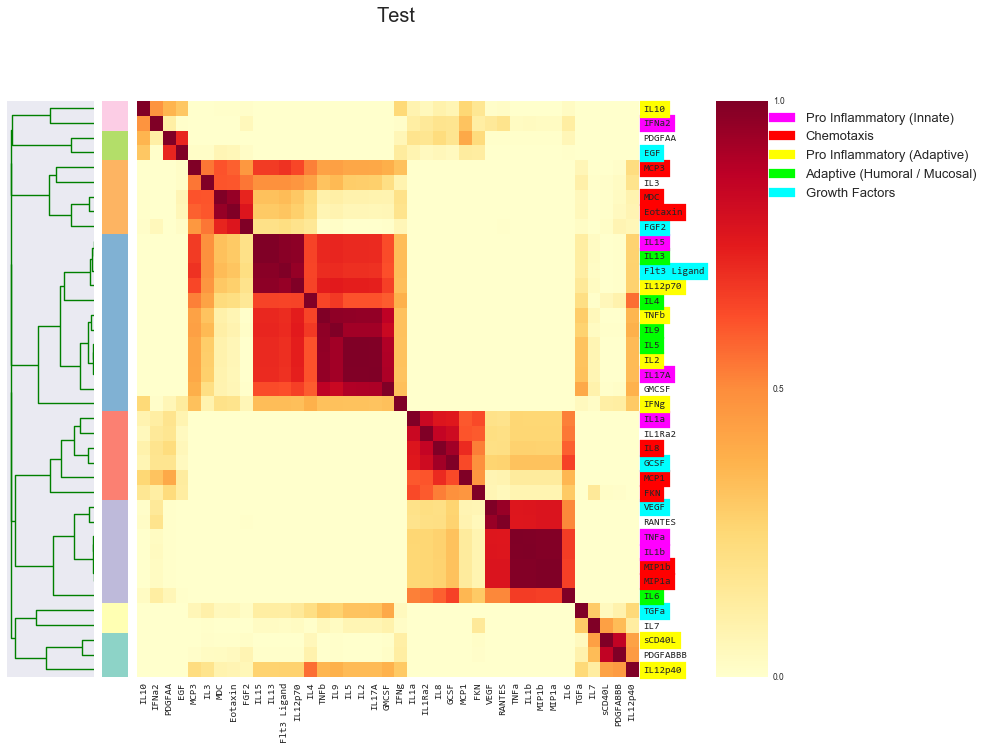

In [116]:
def plotHierClust_1(dmatDf, Z, cmap_2, vRange_2, filename_2, savefile_2=False, labels_2=None, titleStr_2=None, tickSz_2= 10, cmapLabel_2=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_2
    fig = plt.gcf()
    fig.clf()

    if labels_2 is None:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_2 is None:
        cbSE = _colors2labels(labels_2)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_2)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_2 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
    """Add a colorbar"""
    cb = fig.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_2)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Save Graph to Specified Path"""
    if titleStr_2:
        plt.suptitle(titleStr_2, fontsize = 20)
    if savefile_2:
        for file in os.listdir("./{}".format(title_string)):
            if file == filename_2+'.png':
                raise Exception('Directory already contains a file with this filename!')
            else:
                path = "./{}/".format(title_string)
                file_name = op.join(path, filename_2+'.png')
                plt.savefig(file_name, bbox_inches = 'tight')
plt.figure(figsize = (12,10))

plotHierClust_1(1 - rcyc.pwrel,
         cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1],
                 labels_2 = rcyc.labels,
         titleStr_2 = '{}'.format(title_string),
         vRange_2 = (0, 1),
         cmap_2 = cm.YlOrRd,
         filename_2 = '{}'.format(title_string),
         savefile_2 = save_file)

In [96]:
path = "./Flu09/"
file = title_string
filename = op.join(path,file)
# os.makedirs(os.path.dirname("./Strain - A (H3), Adjusted, K = 8"))

os.chdir(path)
os.makedirs(title_string)

cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster\Flu09


FileNotFoundError: [WinError 3] The system cannot find the path specified: './Flu09'

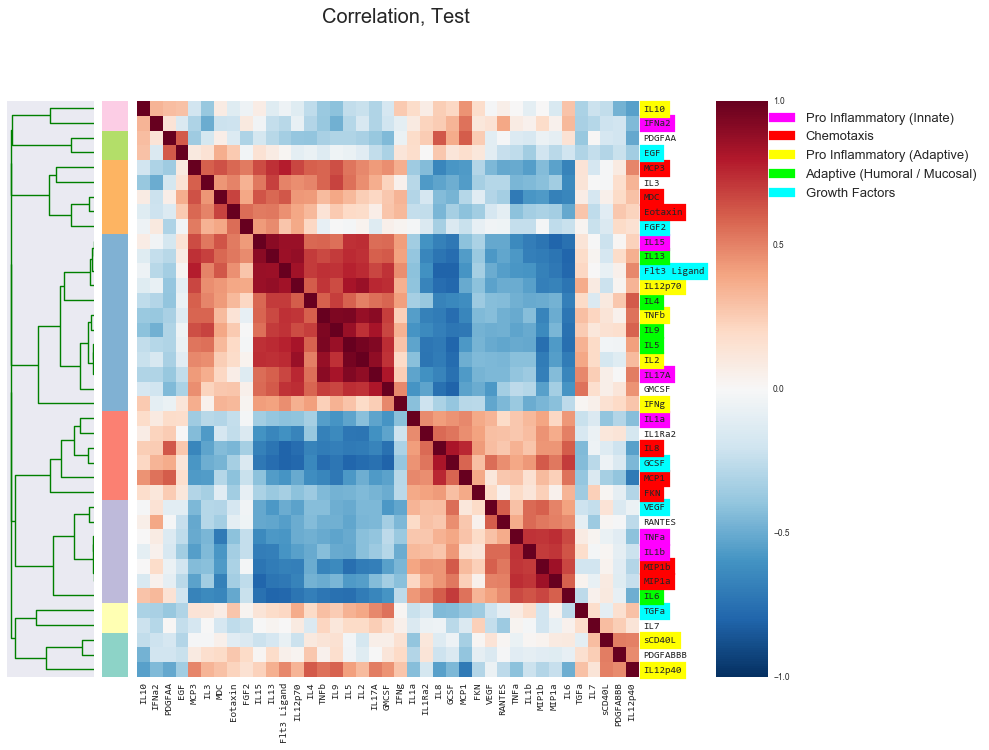

In [103]:
# plt.figure(43, figsize = (15.5, 9.5))
# colInds = plot.plotHierClust(1 - rcyc.pwrel,
#                                rcyc.Z,
#                                labels=rcyc.labels,
#                                titleStr='Pairwise reliability',
#                                vRange=(0, 1),
#                                tickSz='large')


def _colors2labels(labels, setStr = 'Set3', cmap = None):
    """Return pd.Series of colors based on labels"""
    if cmap is None:
        N = max(3, min(12, len(np.unique(labels))))
        cmap = palettable.colorbrewer.get_map(setStr, 'Qualitative', N).mpl_colors
    cmapLookup = {k:col for k, col in zip(sorted(np.unique(labels)), itertools.cycle(cmap))}
    return labels.map(cmapLookup.get)
def _clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in list(ax.spines.values()):
        sp.set_visible(False)
    ax.grid(False)
    # ax.set_axis_bgcolor('white')
def plotHierClust(dmatDf, Z, cmap, vRange, filename, savefile=False, labels=None, titleStr=None, tickSz= 10, cmapLabel=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange
    fig = plt.gcf()
    fig.clf()

    if labels is None:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels is None:
        cbSE = _colors2labels(labels)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')
#     print(heatmapAX.get_yticklabels()[0].get_position())
    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
#     plt.yticks(bbox = [[1, 0], [4, 3]])
    
#     mpatches.FancyBboxPatch((1, 0), 100, 4)
                
#         """Remove the tick lines"""
#         for l in heatmapAX.get_xticklines() + heatmapAX.get_yticklines(): 
#             l.set_markersize(0)

    """Add a colorbar"""
    cb = fig.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Save Graph to Specified Path"""
    if titleStr:
        plt.suptitle(titleStr, fontsize = 20)
    if savefile:
        for file in os.listdir("./Flu09"):
            if file == filename+'.png':
                raise Exception('Directory already contains a file with this filename!')
            else:
                path = "./Flu09/"
                file_name = op.join(path, filename+'.png')
                plt.savefig(file_name, bbox_inches = 'tight')
                
                
    """Create and Save Data Table of Clusters and Cytokines"""
    if savfile:
        dict_1 = {}
        for i in range(len(rcyc.labels.index)):
            dict_1[rcyc.labels.index[i]] = rcyc.labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1):
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        header = [('Cluster', 'Cytokines')]
        header += new_table

        t = Texttable()
        t.add_rows(header)

        text_file = open("Data Table -- {}".format(title_string), "w")
        text_file.write(t.draw())
        text_file.close()
        
        new_dict = {}
            for i in new_table:
                new_dict[i[0]] = i[1]

        text_file_1 = open("cluster_data.txt", "w")
        text_file_1.write(str(new_dict))
        text_file_1.close()
    
    
plt.figure(figsize = (12,10))



plotHierClust(rcyc.cyDf.corr(method="pearson", min_periods=1), 
              rcyc.Z, 
              filename = 'Correlation, {}'.format(title_string),
              cmap = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, 
              vRange = (-1, 1), labels = rcyc.labels, 
              titleStr = "Correlation, {}".format(title_string),
              savefile = save_file)



plotHierClust(1 - rcyc.pwrel,
                    cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1],
                    labels=rcyc.labels,
                    titleStr='{}'.format(title_string),
                    vRange=(0, 1),
                    cmap = cm.YlOrRd,
                    filename = '{}'.format(title_string),
                    savefile = save_file)

In [170]:
# print((rcyc.labels.index))
# print(rcyc.labels.values)
dict_1 = {}
for i in range(len(rcyc[0].labels.index)):
    dict_1[rcyc[0].labels.index[i]] = rcyc[0].labels.values[i]


sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])
# pprint.pprint(sorted_by_value)
# print(sorted_by_value[0][1])
table = {}

for tup in sorted_by_value:
    if tup[1] in table.keys():
        table[tup[1]] += (tup[0],)
    else:
        table[tup[1]] = (tup[0],)

sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])
new_table = []
i = 1
while i < len(sorted_by_value_1):
    for tup in sorted_by_value_1:
        if int(tup[0]) == i:
            new_table += [tup]
            i += 1
        else:
            continue

header = [('Cluster', 'Cytokines', 'Intra-Corr', 'Inter-Corr', 'Corr-Ratio')]
header += new_table
for k, v in corr[0].items():
    for item in header:
        if header.index(item) == k:
            if v:
                new_item = list(item)
                new_item.append(v)
                new_item.append(corr[1])
                new_item.append(corr[2])
                header[header.index(item)] = tuple(new_item)
            else:
                new_item = list(item)
                new_item.append("--")
                new_item.append(corr[1])
                new_item.append(corr[2])
                header[header.index(item)] = tuple(new_item)
            break

print(header)
t = Texttable()
t.add_rows(header)
print(t.draw())
print(len(new_table))
# text_file = open("Test Table.txt", "w")

# text_file.write(t.draw())

# text_file.close()

[('Cluster', 'Cytokines', 'Intra-Corr', 'Inter-Corr', 'Corr-Ratio'), (1, ('IFNg', 'VEGF'), 0.5289, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (2, ('FGF2', 'FKN', 'GMCSF', 'IFNa2', 'MCP3'), 0.163, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (3, ('IL1Ra2', 'IL1b'), 0.2718, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (4, ('IL10', 'IL12p40', 'IL13', 'IL15', 'IL1a', 'IL2', 'IL3', 'IL4', 'IL5', 'IL9', 'TNFb'), 0.3926, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (5, ('Flt3 Ligand', 'IL12p70', 'IL17'), 0.3226, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (6, ('IL6',), '--', array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225])), (7, ('Eotaxin', 'GCSF', 'IP10', 'MCP1', 'MDC'), 0.4642, array([-0.281, -0.103,  0.064]), array([1.479     , 1.52583541, 1.57931225]))]
+---------+------------------+--------

In [223]:
new_dict = {}
for i in new_table:
    new_dict[i[0]] = i[1]

text_file_1 = open("cluster_data.txt", "w")
text_file_1.write(str(new_dict))
text_file_1.close()

{1: ('IL12p40', 'PDGFABBB', 'sCD40L'), 2: ('IL7', 'TGFa'), 3: ('IL1b', 'IL6', 'MIP1a', 'MIP1b', 'RANTES', 'TNFa', 'VEGF'), 4: ('FKN', 'GCSF', 'IL1Ra2', 'IL1a', 'IL8', 'MCP1'), 5: ('Flt3 Ligand', 'GMCSF', 'IFNg', 'IL12p70', 'IL13', 'IL15', 'IL17A', 'IL2', 'IL4', 'IL5', 'IL9', 'TNFb'), 6: ('Eotaxin', 'FGF2', 'IL3', 'MCP3', 'MDC'), 7: ('EGF', 'PDGFAA'), 8: ('IFNa2', 'IL10')}


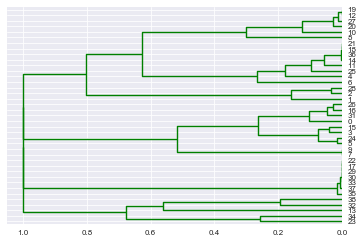

In [15]:
denD = sch.dendrogram(cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1], p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
colInd = denD['leaves']


<Figure size 864x720 with 0 Axes>

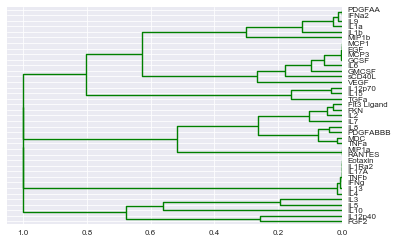

<Figure size 864x720 with 0 Axes>

In [22]:
denD_1 = sch.dendrogram(cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1], p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left', labels = rcyc.pwrel.columns[colInd])
plt.savefig('Dendrogram_test.png', bbox_inches = 'tight')
plt.figure(figsize = (12, 10))


In [20]:
def moduleCorrRatio(cyDf, labels, cyVars=None, alpha=0.05, nstraps=100):
    """Compute all pairwise intra- and inter-module cytokine correlation
    coefficients with their IQRs.

    Additionally compute the intra : inter ratio with 95% CI, where the
    ratio is of signed-pearson correlation coefficients transformed to
    the [0,1] interval with 0 meaning perfect anti-correlation
    and 1 meaning perfect correlation
    
    For ratio, uses a signed Pearson correlation coefficient since this is what is used
    for clustering. The disadvantage is that it can't be described as fractional
    variance, while the upside is that it captures the potential problem with
    forming modules of anti-correlated cytokines.

    Parameters
    ----------
    cyDf : pd.DataFrame [n_participants x n_cytokines]
        Raw or normalized analyte log-concentrations.
    labels : pd.Series
        Module labels for each analyte

    Returns
    -------
    intra : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs within the same module.
    inter : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs from different modules.
    ratio : np.ndarray shape (3,)
        Vector containing the intra : inter correlation ratio with bootstrap 95% CI or (1 - alpha)%
        [LB, ratio, UB]"""

    def ratioFunc(cyDf, intraMask, interMask):
        """smat is on the [0, 1] interval with 0 meaning perfect anti-correlation and 1 meaning perfect correlation"""
        smat = 1 - cy.corrDmatFunc(cyDf, metric='pearson-signed').values
        return np.nanmean((smat * intraMask).ravel()) / np.nanmean((smat * interMask).ravel())

    if cyVars is None:
        cyVars = cyDf.columns.tolist()

    """corrmat is on the [-1, 1] interval with 1 meaning perfect correlation and -1 meaning perfect anti-correlation"""
    corrmat = cyDf[cyVars].corr()

    intra = []
    inter = []
    intraMask = np.nan * np.zeros(corrmat.shape)
    interMask = np.nan * np.zeros(corrmat.shape)
    for a, b in itertools.combinations(cyVars, 2):
        if not a == b:
            s = corrmat.loc[a, b]
            i, j = cyVars.index(a), cyVars.index(b)
            if labels[a] == labels[b]:
                intra.append(s)
                intraMask[i, j] = 1.
            else:
                inter.append(s)
                interMask[i, j] = 1.

    intra = np.percentile(intra, q=[25, 50, 75])
    inter = np.percentile(inter, q=[25, 50, 75])

    if nstraps is None or nstraps == 0:
        return intra, inter
    
    else:
        rratios = np.zeros(nstraps)
        for strapi in range(nstraps):
            rratios[strapi] = ratioFunc(cyDf[cyVars].sample(frac=1, replace=True, axis=0), intraMask, interMask)
        ratio = np.percentile(rratios, [100*alpha/2, 50, 100*(1-alpha/2)])

        return intra, inter, ratio
    
moduleCorrRatio(rcyc[0].cyDf, rcyc[0].labels)




(array([0.3815889 , 0.45822608, 0.57751636]),
 array([-0.26258363, -0.06846859,  0.13528256]),
 array([1.53091553, 1.56335076, 1.5977643 ]))

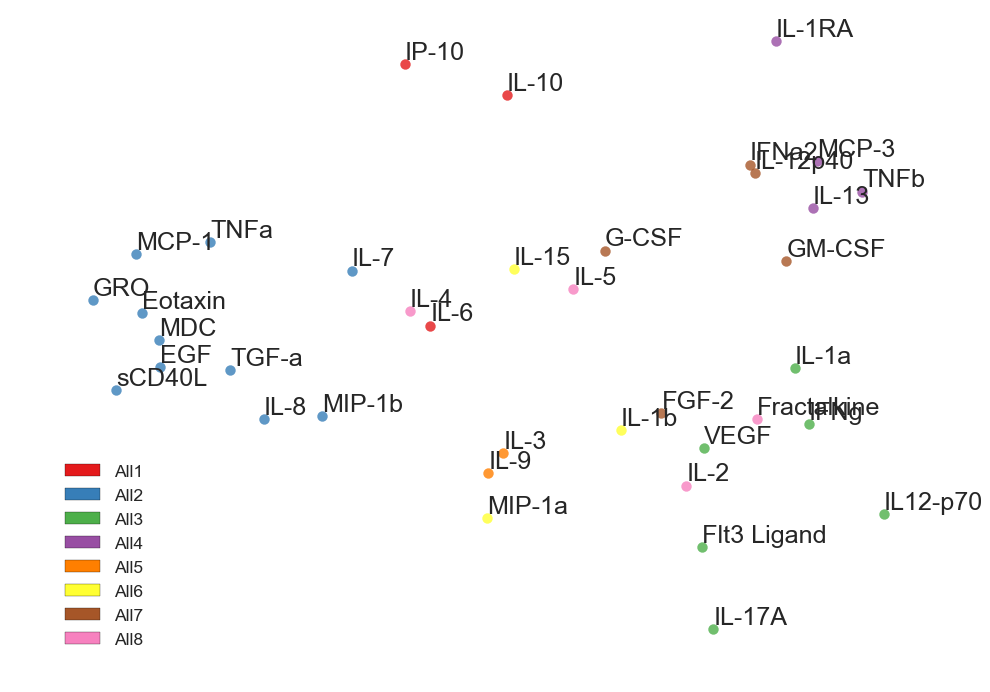

In [549]:
plt.figure(901, figsize=(13, 9.7))
plot.plotModuleEmbedding(rcyc.dmatDf, rcyc.labels, method='kpca', txtSize='large')
colors = palettable.colorbrewer.get_map('Set1', 'qualitative', len(np.unique(rcyc.labels))).mpl_colors
colorLegend(colors, ['%s%1.0f' % (rcyc.sampleStr, i) for i in np.unique(rcyc.labels)], loc='lower left')


In [15]:
import scipy.stats

"""df here should have one column per module and the genotype column"""
ptidDf = longDf[['ptid', 'sample', 'genotype', 'dpi']].drop_duplicates().set_index('ptid')
df = rcyc.modDf.join(ptidDf)

ind = df.genotype == 'WT'
col = 'LUNG1'
# stats.ranksums(df[col].loc[ind], df[col].loc[~ind])


